In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # draw
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import wandb

import wakatime

In [2]:
train_data = pd.read_csv("./data/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("./data/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
def process_train_data(train_data):
    # Step 1: 'Sex' 列数值映射
    if train_data['Sex'].dtype == 'object':
        train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
    
    # Step 2: One-Hot 编码 'Embarked' 列
    if 'Embarked' in train_data.columns:
        train_data = pd.get_dummies(train_data, columns=['Embarked'], drop_first=False)

    # Step 3: 将布尔类型的列转换为整型 (0 和 1)
    for col in train_data.select_dtypes(include=['bool']).columns:
        train_data[col] = train_data[col].astype(int)

    # Step 4: 选择数值型数据
    numeric_data = train_data.select_dtypes(include=[float, int])
    
    # Step 5: 计算相关性矩阵
    correlation_matrix = numeric_data.corr()
    
    return correlation_matrix

corr = process_train_data(train_data)

In [6]:
def process_test_data(test_data):
    if test_data['Sex'].dtype == 'object':
        test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})

    if 'Embarked' in test_data.columns:
        test_data = pd.get_dummies(test_data, columns=['Embarked'], drop_first=False)
    
    for col in test_data.select_dtypes(include=['bool']).columns:
        test_data[col] = test_data[col].astype(int)
    
    return
process_test_data(test_data)

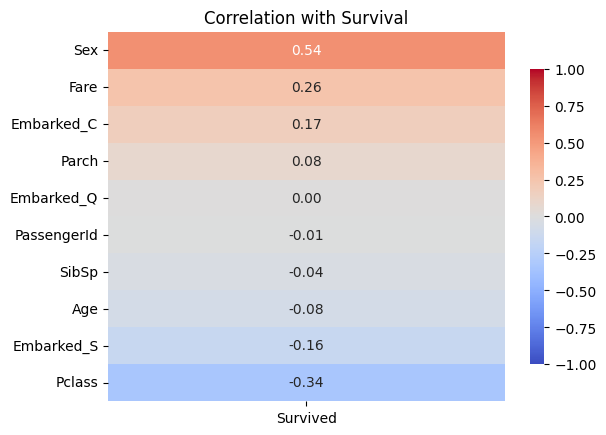

In [7]:
survived_corr = corr['Survived'].drop('Survived')
survived_corr = survived_corr.sort_values(ascending=False)

sns.heatmap(survived_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.title('Correlation with Survival')
plt.show()

In [8]:
def prepare_data(train_data):

    features = ['Sex','Pclass','Fare','Age']

    X = train_data[features]
    y = train_data['Survived']

    X.loc[:, 'Age'] = X['Age'].fillna(X['Age'].median())
    
    # 标准化处理
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # 转换为 PyTorch 张量
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

    # 划分训练集和验证集
    X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, random_state=0)

    return X_train, X_test, y_train, y_test, scaler

In [9]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [10]:
def train(train_data, epochs=1000, learning_rate=0.016):
    
    X_train, X_test, y_train, y_test, scaler = prepare_data(train_data)

    input_dim = X_train.shape[1]
    model = LogisticRegressionModel(input_dim)
    
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    wandb.init(project="Titanic", reinit=True, dir="./wandb_temp")
    config = wandb.config
    config.learning_rate = learning_rate
    config.epochs = epochs

    # 监控模型参数和梯度
    wandb.watch(model)
    
    # 训练循环
    for epoch in range(epochs):
        model.train()

        # 前向传播
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if (epoch + 1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_test)
                val_loss = criterion(val_outputs, y_test)
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
                
                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": loss.item(),
                    "val_loss": val_loss.item()
                })
                
    wandb.finish()
    
    return model, scaler

In [11]:
def predict_and_save_submission(model, test_data, scaler):

    X_test = test_data[['Sex', 'Pclass', 'Fare', 'Age']]  # 使用相同的特征
    X_test.loc[:, 'Age'] = X_test['Age'].fillna(X_test['Age'].median())

    # 标准化处理
    X_test = scaler.transform(X_test)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    
    # 模型预测
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        predicted_labels = (predictions.numpy() > 0.5).astype(int)  # 将输出转换为二进制标签
    
    # 创建提交文件
    submission = pd.DataFrame({
        'PassengerId': test_data['PassengerId'],
        'Survived': predicted_labels.flatten()
    })
    
    # 保存为csv文件
    submission.to_csv('submission.csv', index=False)
    print("预测结果已保存为 submission.csv")

In [12]:
model, scaler = train(train_data)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: 3131492575 (3131492575-). Use `wandb login --relogin` to force relogin
wandb: WARNING Path ./wandb_temp\wandb\ wasn't writable, using system temp directory.


Epoch [100/1000], Loss: 0.5179, Val Loss: 0.5156
Epoch [200/1000], Loss: 0.4906, Val Loss: 0.4825
Epoch [300/1000], Loss: 0.4775, Val Loss: 0.4658
Epoch [400/1000], Loss: 0.4705, Val Loss: 0.4563
Epoch [500/1000], Loss: 0.4664, Val Loss: 0.4505
Epoch [600/1000], Loss: 0.4640, Val Loss: 0.4467
Epoch [700/1000], Loss: 0.4624, Val Loss: 0.4441
Epoch [800/1000], Loss: 0.4613, Val Loss: 0.4423
Epoch [900/1000], Loss: 0.4606, Val Loss: 0.4409
Epoch [1000/1000], Loss: 0.4601, Val Loss: 0.4399


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▅▃▂▂▁▁▁▁▁
val_loss,█▅▃▃▂▂▁▁▁▁
epoch,1000
train_loss,0.46009
val_loss,0.43986


In [13]:
predict_and_save_submission(model, test_data, scaler)

预测结果已保存为 submission.csv
